# 統計検定準1級を意識したSVMの理論と実装

## セル1：はじめに
### 見出し：サポートベクトルマシン（SVM）とは？
(Markdown)

サポートベクトルマシン（SVM）は、分類や回帰に用いられる教師あり学習アルゴリズムです。特に、**マージン最大化**という考え方に基づき、クラスを最もよく分離する決定境界（超平面）を見つけることが特徴です。

**統計検定準1級との関連:**
単なるライブラリの使用法だけでなく、その背後にある数理的理論、特に**最適化問題**、**カーネル法**、**ハイパーパラメータ**の意味についての理解が問われます。
このノートブックでは、`scikit-learn`の実装を通じて、SVMの数理的な概念を深く掘り下げていきます。

---

## セル2：線形SVMの数学的定式化
### 見出し：線形分離可能な場合の数学的基礎
(Markdownと数式)

線形分離可能なデータ（ハードマージン）に対して、SVMはマージンを最大化するような超平面を求めます。
超平面は、重みベクトル $w$ とバイアス $b$ を用いて次のように表現されます。

$$w \cdot x + b = 0$$

このとき、各クラスに最も近いサンプル（**サポートベクトル**）は、以下の境界上にあるとします。
* クラス +1: $w \cdot x_i + b = +1$
* クラス -1: $w \cdot x_i + b = -1$

マージンは、これら2つの境界間の距離であり、 $\frac{2}{||w||}$ で表されます。マージンを最大化することは、$||w||$ を最小化することに等しいです。（厳密には $\frac{1}{2} ||w||^2$ を最小化します）

したがって、この最適化問題は以下のように定式化されます。

* **目的関数（最小化）:**
    $$\min_{w,b} \frac{1}{2} ||w||^2$$
* **制約条件:**
    $$y_i (w \cdot x_i + b) \ge 1 \quad (\forall i)$$

ここで、$y_i \in \{-1, +1\}$ はクラスラベルです。

---

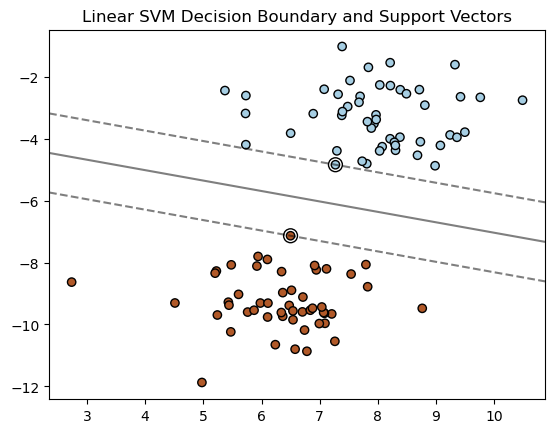

In [2]:
## セル3：Python実装：線形SVM
### 見出し：scikit-learnによる線形SVMの実装
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# 1. サンプルデータの生成（線形分離可能なものを想定）
X, y = datasets.make_blobs(n_samples=100, centers=2, random_state=6)
# クラスラベルを-1と+1に設定 (統計検定の数式表記に合わせる)
y[y == 0] = -1

# 2. モデルの初期化と学習
# kernel='linear' がセル2の数式（線形SVM）に対応
# C=1000 (大きい値) を設定し、誤分類を許さないハードマージンに近い設定にする
model_linear = svm.SVC(kernel='linear', C=1000)
model_linear.fit(X, y)

# 3. 決定境界の可視化
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 決定境界のメッシュを作成
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model_linear.decision_function(xy).reshape(XX.shape)

# 決定境界(f(x)=0)とマージン(f(x)=±1)をプロット
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# サポートベクトルをプロット
ax.scatter(model_linear.support_vectors_[:, 0], model_linear.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.title("Linear SVM Decision Boundary and Support Vectors")
plt.show()

### 見出し：非線形分離可能な場合の拡張：ソフトマージン
(Markdownと数式)

現実のデータは、完全に線形分離可能であることは稀です。そこで、誤分類を許容する**ソフトマージンSVM**を考えます。これは、**スラック変数 $\xi_i \ge 0$** （クシー）を導入することで実現されます。

$\xi_i$ は、サンプル $i$ がどれだけマージン制約を違反しているかを表します。

目的関数に、この違反に対するペナルティ項を追加します。

* **目的関数（最小化）:**
    $$\min_{w,b,\xi} \frac{1}{2} ||w||^2 + C \sum_{i=1}^n \xi_i$$
* **制約条件:**
    $$y_i (w \cdot x_i + b) \ge 1 - \xi_i \quad (\forall i)$$
    $$\xi_i \ge 0 \quad (\forall i)$$

**ハイパーパラメータ $C$:**
$C$ は、マージンの最大化（$||w||^2$ の最小化）と、誤分類のペナルティ（$\sum \xi_i$ の最小化）との**トレードオフ**を調整します。

* **$C$ が小さい:** 誤分類を多く許容し、マージンが広くなる（バイアス大、バリアンス小）。
* **$C$ が大きい:** 誤分類を厳しく罰し、マージンが狭くなる（バイアス小、バリアンス大）。

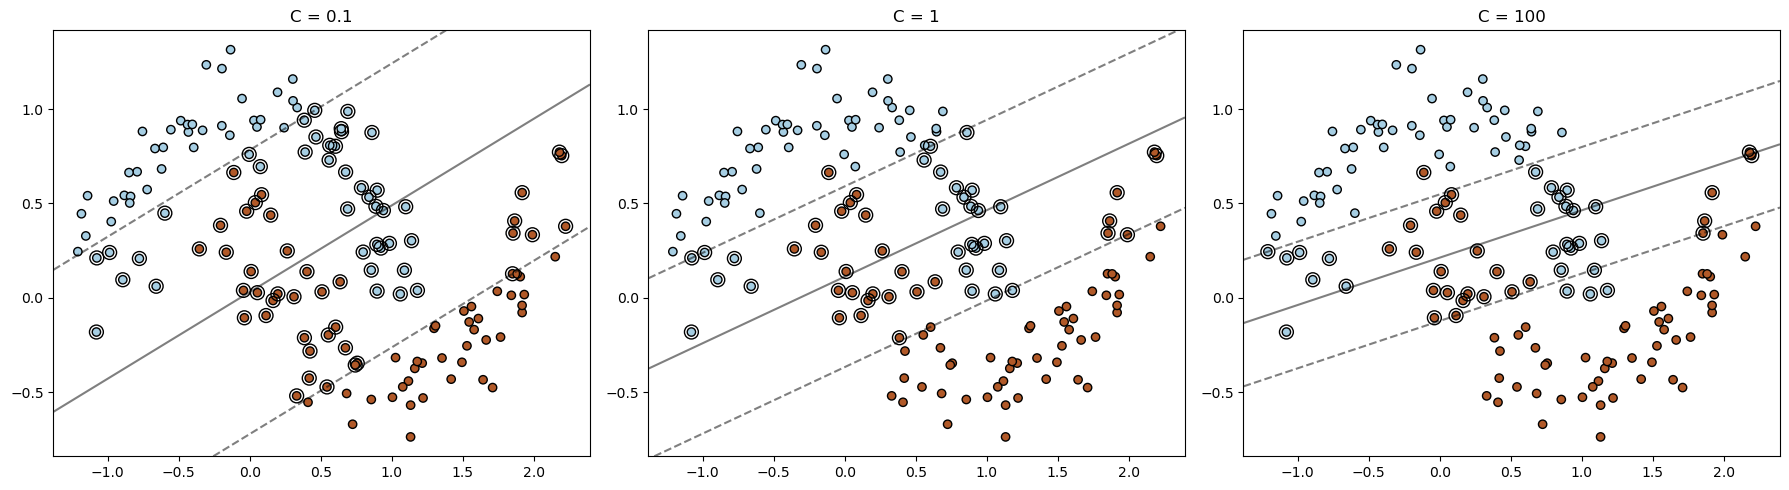

In [3]:
### 見出し：Cの影響を確認する
# make_moonsを使って非線形なデータを生成
X_moon, y_moon = datasets.make_moons(n_samples=150, noise=0.15, random_state=42)
y_moon[y_moon == 0] = -1 # ラベルを -1, +1 に

# 異なるCの値で比較
C_values = [0.1, 1, 100]

plt.figure(figsize=(18, 5))
for i, C in enumerate(C_values):
    # C以外は同じ条件 (kernel='linear') で比較
    model_soft = svm.SVC(kernel='linear', C=C)
    model_soft.fit(X_moon, y_moon)

    plt.subplot(1, len(C_values), i + 1)
    plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=plt.cm.Paired, edgecolors='k')
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model_soft.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    ax.scatter(model_soft.support_vectors_[:, 0], model_soft.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.title(f"C = {C}")

plt.tight_layout()
plt.show()

考察: Cが小さい（左）ほどマージンが広く（誤分類を許容）、Cが大きい（右）ほどマージンが狭く（誤分類を厳罰化）なっていることが視覚的に確認できます。

### 見出し：カーネルトリック：非線形分離への対応
(Markdownと数式)

線形分離不可能なデータを扱うために、元の入力空間 $x$ を、より高次元の特徴空間 $\phi(x)$ に写像します。

* 超平面は特徴空間で線形: $w \cdot \phi(x) + b = 0$

このとき、最適化問題は（ラグランジュの未定乗数法を用いて）**双対形式**で解かれ、計算は $x_i$ と $x_j$ の内積の形でのみ現れます。
特徴空間での内積 $\phi(x_i) \cdot \phi(x_j)$ の計算が必要となります。

**カーネルトリック:**
この高次元空間での内積計算 $\phi(x_i) \cdot \phi(x_j)$ を、高次元への写像 $\phi$ を明示的に計算することなく、元の空間 $x_i, x_j$ だけで計算する手法です。
この計算を行う関数を**カーネル関数 $K(x_i, x_j)$** と呼びます。

$$K(x_i, x_j) = \phi(x_i) \cdot \phi(x_j)$$

**代表的なカーネル関数:**
* **ガウシアン（RBF）カーネル:**
    $$K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$$
    パラメータ $\gamma$（ガンマ）は、データ点の影響範囲を制御します。$\gamma$ が大きいほど、影響範囲は狭くなります。

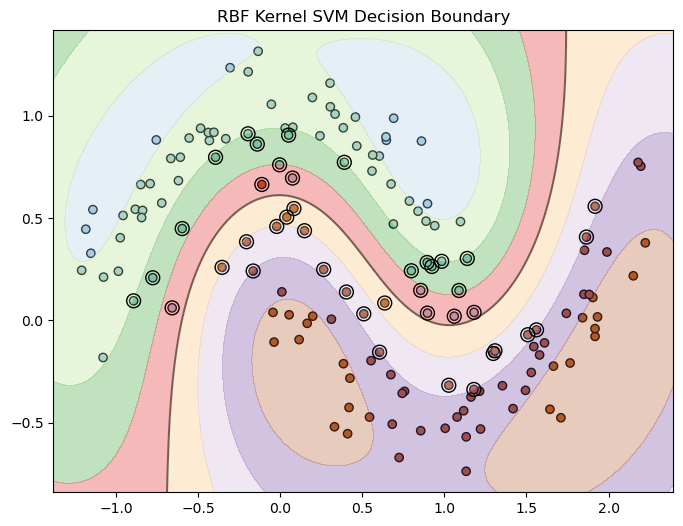

In [6]:
# セル5のmake_moonsデータを使用
# X_moon, y_moon

# RBFカーネルSVMモデルの学習
# kernel='rbf' がセル6のRBFカーネルに対応
# C=1.0, gamma='scale' (scikit-learnのデフォルトの一つ) を使用
model_rbf = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
model_rbf.fit(X_moon, y_moon)

# 決定境界の可視化
plt.figure(figsize=(8, 6))
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=plt.cm.Paired, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# メッシュを細かくして滑らかな境界を描画
xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model_rbf.decision_function(xy).reshape(XX.shape)

# 決定領域を色付け (contourf)
ax.contourf(XX, YY, Z, cmap=plt.cm.Paired, alpha=0.3)
# 決定境界(f(x)=0)も描画
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

ax.scatter(model_rbf.support_vectors_[:, 0], model_rbf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title("RBF Kernel SVM Decision Boundary")
plt.show()

### 見出し：モデルの検証とハイパーパラメータ探索
(MarkdownとPythonコード)

統計検定では、モデルの性能を正しく評価する能力が求められます。特に、RBFカーネルにおける $C$ や $\gamma$ といったハイパーパラメータの適切な選択は、モデルの**汎化性能**に直結します。

* **交差検証（Cross-Validation, CV）:**
    データを訓練データと検証データに分割し、未知のデータに対する性能（汎化性能）を評価する手法です。
* **グリッドサーチ（Grid Search）:**
    指定されたハイパーパラメータの組み合わせ（グリッド）を総当たりで試し、交差検証によって最も性能が良い組み合わせを見つけます。


In [7]:
from sklearn.model_selection import GridSearchCV

# 探索するパラメータグリッドの定義
# C (コスト) と gamma (RBFカーネルのパラメータ)
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 1, 10, 'scale', 'auto']}

# グリッドサーチの設定 (cv=5 は 5-fold Cross-Validation を意味する)
# 評価指標(scoring)を指定することも可能
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5, verbose=2)

# グリッドサーチの実行
grid_search.fit(X_moon, y_moon)

# 最適なパラメータの表示
print("\n--- グリッドサーチ結果 ---")
print("最適なパラメータ:", grid_search.best_params_)
print("最高の交差検証スコア (Accuracy):", grid_search.best_score_)

# 最適なモデル（ベストなCとgammaの組み合わせ）は grid_search.best_estimator_ に格納されている
best_model = grid_search.best_estimator_
print("\n最適なモデル:", best_model)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ....................................C=0.1, gamma=10; total time=   0.0s
[CV] END ....................................C=